# The overview of the basic approaches to solving the Uplift Modeling problem

<br>
<center> 
  <b><a href="https://github.com/maks-sh/scikit-uplift/">SCIKIT-UPLIFT REPO</a> | </b>
  <b><a href="https://github.com/maks-sh/scikit-uplift/blob/master/notebooks/RetailHero_EN.ipynb">RUSSIAN VERSION</a></b>
</center>

## Content

* [Introduction](#Introduction)
* [1. Approaches with the same model](#1.-Approaches-with-the-same-model)
    * [1.1 One model](#1.1-One-model-with-treatment-as-a-feature)
    * [1.2 Class Transformation](#1.2-Class-Transformation)
* [2. Approaches with two models](#2.-Approaches-with-two-models)
    * [2.1 Two independent models](#2.1-Two-independent-models)
    * [2.2 Two dependent models](#2.2-Two-dependent-models)
* [Conclusion](#Conclusion)

## Introduction

Before proceeding to the discussion of uplift modeling, let's imagine some situation:

A customer comes to you with a certain problem: it is necessary to advertise a popular product using the sms.
You know that the product is quite popular, and it is often installed by the customers without communication, that the usual binary classification will find the same customers, and the cost of communication is critical for us...

And then you begin to understand that the product is already popular, that the product is often installed by customers  without communication, that the usual binary classification will find many such customers, and the cost of communication is critical for us...

Historically, according to the impact of communication, marketers divide all customers into 4 categories:

<p align="center">
  <img src="https://raw.githubusercontent.com/maks-sh/scikit-uplift/master/docs/_static/images/client_types.png" alt="Customer types"/>
</p>

1. **Sleeping dog (or Do Not Disturb)** is a person who will react negatively if you communicate. A striking example: the customers who forgot about a paid subscription. When they receive a reminder about this, they will disable the subscription. It turns out that the customers will still bring in money if you don’t touch them.
2. **Lost Causes** is a person who will not perform a targeted action in spite of making the communication with them. The Interaction with such clients does not generate the additional revenue but creates the additional costs.
3. **Sure Things** is a person who will respond positively no matter what. It’s the most loyal type of the customers. Similarly, to the previous paragraph, these clients also spend resources. However, in this case, the costs are much higher, because the **confident** also uses the marketing offer (discounts, coupons, and more).
4. **Persuadables** is a person who responds positively to an offer, but in its absence would not have fulfilled the target action. These are the people we would like to define as our model in order to communicate with them

We should mention about the depending on the client base and the company's characteristics. Some types of clients may not be available.

Thus, in this task, we don’t want to predict the probability of performing a target action, but to focus the advertising budget on the customers who will perform the target action only when we interact. In other words, we want to evaluate two conditional probabilities separately for each client:


* Performing a targeted action when we influence the client. 
    We will refer such clients to the **test group (aka treatment)**: $P^T = P(Y=1 | W = 1)$,
* Performing a targeted action without affecting the client. 
    We will refer such clients to the **control group (aka control)**: $P^C = P(Y=1 | W = 0)$,

where $Y$ is the binary flag for executing the target action, and $W$ is the binary flag for communication (in English literature, _treatment_)

The very same cause-and-effect effect is called **uplift** and is estimated as the difference between these two probabilities:

$$ uplift = P^T - P^C = P(Y = 1 | W = 1) - P(Y = 1 | W = 0)$$

Predicting uplift is a cause-and-effect inference task. The point is that you need to evaluate the difference between two events that are mutually exclusive for a particular client (either we interact with a person, or not; you can't perform two of these actions at the same time). This is why additional requirements for source data are required for building uplift models.

To get a training sample for the uplift simulation, you need to conduct an experiment: 
1. Randomly split a representative part of the client base into a test and control group
2. Communicate with the test group

The data obtained as part of the design of such a pilot will allow us to build an uplift forecasting model in the future. It is also worth noting that the experiment should be as similar as possible to the campaign, which will be launched later on a larger scale. The only difference between the experiment and the campaign should be the fact that during the pilot, we choose random clients for interaction, and during the campaign - based on the predicted value of the Uplift. If the campaign that is eventually launched differs significantly from the experiment that is used to collect data about the performance of targeted actions by clients, then the model that is built may be less reliable and accurate.

So, the approaches to predicting uplift are aimed at assessing the net effect of marketing campaigns on customers.

All classical approaches to uplift modeling can be divided into two classes:
1. Approaches with the same model
2. Approaches using two models

We download [contest data RetailHero.ai](https://retailhero.ai/c/uplift_modeling/overview):

In [0]:
import urllib.request

print('Beginning file download with urllib2...')

url = 'https://drive.google.com/u/0/uc?id=1fkxNmihuS15kk0PP0QcphL_Z3_z8LLeb&export=download'
urllib.request.urlretrieve(url, '/content/retail_hero.zip')

!unzip /content/retail_hero.zip
!pip install scikit-uplift
!pip install catboost

Beginning file download with urllib2...
Archive:  /content/retail_hero.zip
  inflating: uplift_data/uplift_train.csv  
  inflating: uplift_data/uplift_test.csv  
  inflating: uplift_data/clients.csv  
     |████████████████████████████████| 64.4MB 77kB/s 


Now let's preprocess it a bit:

In [0]:
%matplotlib inline

import pandas as pd; pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split


# reading data
df_clients = pd.read_csv('/content/uplift_data/clients.csv', index_col='client_id')
df_train = pd.read_csv('/content/uplift_data/uplift_train.csv', index_col='client_id')
df_test = pd.read_csv('/content/uplift_data/uplift_test.csv', index_col='client_id')

# extracting features
df_features = df_clients.copy()
df_features['first_issue_time'] = \
    (pd.to_datetime(df_features['first_issue_date'])
     - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')
df_features['first_redeem_time'] = \
    (pd.to_datetime(df_features['first_redeem_date'])
     - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')
df_features['issue_redeem_delay'] = df_features['first_redeem_time'] \
    - df_features['first_issue_time']
df_features = df_features.drop(['first_issue_date', 'first_redeem_date'], axis=1)

indices_train = df_train.index
indices_test = df_test.index
indices_learn, indices_valid = train_test_split(df_train.index, test_size=0.3, random_state=123)

For convenience, we will declare some variables:

In [0]:
X_train = df_features.loc[indices_learn, :]
y_train = df_train.loc[indices_learn, 'target']
treat_train = df_train.loc[indices_learn, 'treatment_flg']

X_val = df_features.loc[indices_valid, :]
y_val = df_train.loc[indices_valid, 'target']
treat_val =  df_train.loc[indices_valid, 'treatment_flg']

X_train_full = df_features.loc[indices_train, :]
y_train_full = df_train.loc[:, 'target']
treat_train_full = df_train.loc[:, 'treatment_flg']

X_test = df_features.loc[indices_test, :]

cat_features = ['gender']

models_results = {
    'approach': [],
    'uplift@30%': []
}

## 1. Approaches with the same model

### 1.1 One model with treatment as a feature

The simplest and most intuitive solution is when the model is trained simultaneously on two groups, with the binary communication flag acting as an additional feature. Each object from the test sample is scored twice: with the communication flag equal to 1 and equal to 0. Subtracting the probabilities for each observation, we get the required uplift.

<p align="center">
  <img src="https://raw.githubusercontent.com/maks-sh/scikit-uplift/master/docs/_static/images/SoloModel.png" alt="Solo model with treatment as a feature"/>
</p>

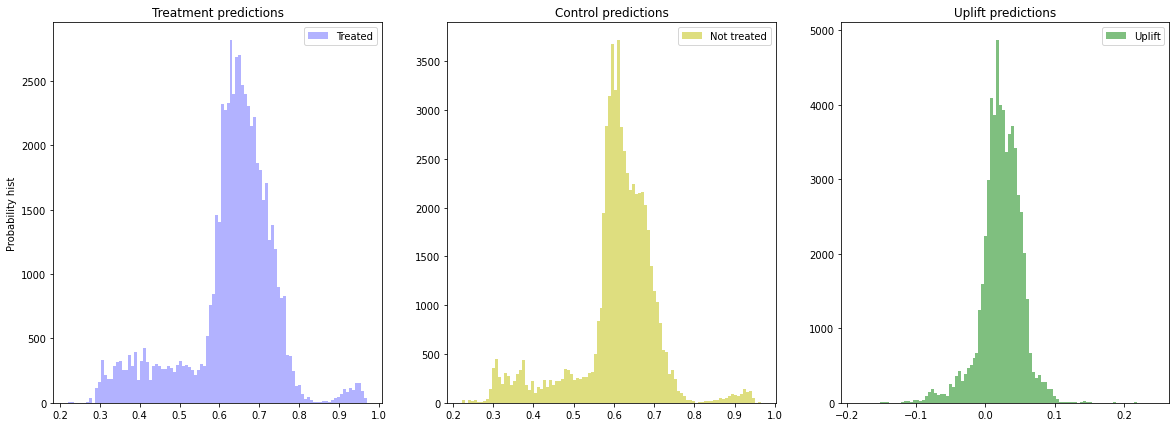

In [0]:
# installation instructions: https://github.com/maks-sh/scikit-uplift
# link to the documentation: https://scikit-uplift.readthedocs.io/en/latest/
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel

# sklift supports all models, 
# that satisfy scikit-learn convention
# for example, let's use catboost
from catboost import CatBoostClassifier


sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_val)

sm_score = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, k=0.3)

models_results['approach'].append('SoloModel')
models_results['uplift@30%'].append(sm_score)

# get conditional probabilities (predictions) of performing the target action 
# during interaction for each object
sm_trmnt_preds = sm.trmnt_preds_
# And conditional probabilities (predictions) of performing the target action 
# without interaction for each object
sm_ctrl_preds = sm.ctrl_preds_

# draw the probability (predictions) distributions and their difference (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

In [0]:
# You can also access the trained model with the same ease.
# For example, to build the importance of features:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,first_redeem_time,65.214393
1,issue_redeem_delay,12.564364
2,age,7.891613
3,first_issue_time,7.262806
4,treatment,4.362077
5,gender,2.704747


### 1.2 Class Transformation

Quite an interesting and mathematically confirmed approach to building a model, presented in 2012. The method is to predict a slightly changed target:

$$
z_i = y_i * w_i + (1-y_i) * (1 - w_i),
$$
where 

* $z_i$ - new target variable of the$i $ client; 
* $y_i$ - target variable of the$i $ client;
* $w_i$ - flag for communication of the$i $ client;  


In other words, the new class is 1 if we know that on a particular observation, the result in the interaction would be as good as in the control group if we could know the result in both groups:

$$
z_i = \begin{cases} 
    1, & \mbox{if} w_i = 1 \mbox{ and } y_i = 1 \\ 
    1, & \mbox{if} w_i = 0 \mbox{ and } y_i = 0 \\
    0, & \mbox{in all other cases} 
   \end{cases}
$$

Let's describe in more detail what is the probability of a new target variable:

$$ 
P(Z=1|X_1, ..., X_m) = \\
= P(Z=1|X_1, ..., X_m, W = 1) * P(W = 1|X_1, ..., X_m, ) + \\
+ P(Z=1|X_1, ..., X_m, W = 0) * P(W = 0|X_1, ..., X_m, ) = \\
= P(Y=1|X_1, ..., X_m, W = 1) * P(W = 1|X_1, ..., X_m, ) + \\
+ P(Y=0|X_1, ..., X_m, W = 0) * P(W = 0|X_1, ..., X_m, ).
$$

We assume that $ W $ does not depend on the attributes of $ X_1, ..., X_m $, because otherwise the experiment design is not very well designed. Taking this, we have: $ P(W | X_1, ..., X_m, ) = P(W) $ and 

$$
P(Z=1|X_1, ..., X_m) = \\
= P^T(Y=1|X_1, ..., X_m) * P(W = 1) + \\
+ P^C(Y=0|X_1, ..., X_m) * P(W = 0).
$$

Also assume that $P(W = 1) = P(W = 0) = \frac{1}{2}$, i.e. during the experiment, the control and test groups were divided in equal proportions. Then we get the following:

$$
P(Z=1|X_1, ..., X_m) = 
P^T(Y=1|X_1, ..., X_m) * \frac{1}{2} + P^C(Y=0|X_1, ..., X_m) *\frac{1}{2} \Rightarrow \\
\Rightarrow 2 * P(Z=1|X_1, ..., X_m) = P^T(Y=1|X_1, ..., X_m) + P^C(Y=0|X_1, ..., X_m) = \\
= P^T(Y=1|X_1, ..., X_m) + 1 - P^C(Y=1|X_1, ..., X_m) \Rightarrow \\
\Rightarrow P^T(Y=1|X_1, ..., X_m) - P^C(Y=1|X_1, ..., X_m) = UPLIFT = 2 * P(Z=1|X_1, ..., X_m) - 1
$$

Thus, by doubling the forecast of the new target and subtracting one from it, we get the value of the uplift itself, i.e.

$$
UPLIFT = 2 * P(Z=1) - 1
$$

Based on the assumption described above: $P(W = 1) = P(W = 0) = \frac{1}{2}$, this approach should only be used in cases where the number of clients we have communicated with is equal to the number of clients we have not communicated with.

In [0]:
from sklift.models import ClassTransformation


ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_val)

ct_score = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, k=0.3)

models_results['approach'].append('ClassTransformation')
models_results['uplift@30%'].append(ct_score)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  """


## 2. Approaches with two models

The two-model approach can be found in almost any uplift modeling work and is often used as a baseline. However, using two models can lead to some unpleasant consequences: if you use fundamentally different models for training, or if the nature of the test and control group data is very different, then the scores returned by the models will not be comparable. As a result, the calculation of the uplift will not be completely correct. To avoid this effect, you need to calibrate the models so that their scores can be interpolated as probabilities. The calibration of model probabilities is described perfectly in [scikit-learn documentation](https://scikit-learn.org/stable/modules/calibration.html).

### 2.1 Two independent models

As the name implies, the approach models the conditional probabilities of the test and controls groups separately. The articles argue that this approach is rather weak, because both models focus on predicting the results separately and can skip the "weaker" differences in the samples therefore.

<p align= "center">
  <img src="https://raw.githubusercontent.com/maks-sh/scikit-uplift/master/docs/_static/images/TwoModels_vanila.png" alt="Two Models vanila"/>
</p>

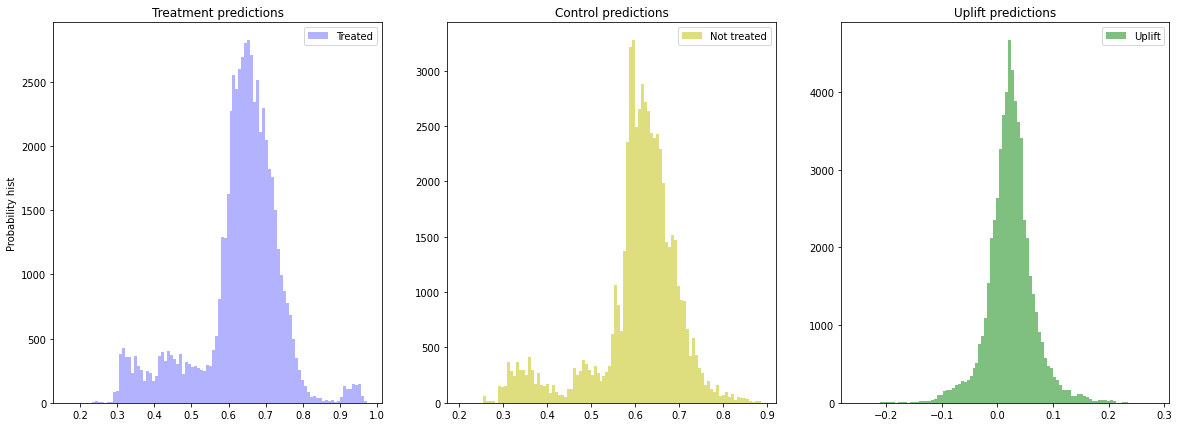

In [0]:
from sklift.models import TwoModels


tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_val)

tm_score = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, k=0.3)

models_results['approach'].append('TwoModels')
models_results['uplift@30%'].append(tm_score)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

### 2.2 Two dependent models

The dependent data representation approach is based on the classifier chain method originally developed for multi-class classification problems. The idea is that if there are $L$ different labels, you can build $L$ different classifiers, each of which solves the problem of binary classification and in the learning process, each subsequent classifier uses the predictions of the previous ones as additional features. The authors of this method suggested using the same idea to solve the problem of uplift modeling in two stages. At the beginning we train the classifier based on control data: 

$$
P^C = P(Y=1| X, W = 0),
$$

then we will perform the $P_C$ predictions as a new feature for training the second classifier on test data, thus effectively introducing a dependency between the two data sets:

$$
P^T =  P(Y=1| X, P_C(X), W = 1)
$$

To get the uplift for each observation, calculate the difference:

$$
uplift(x_i) = P^T(x_i, P_C(x_i)) - P^C(x_i)
$$

Intuitively, the second classifier examines the difference between the expected result in the test and the control, i.e. the uplift itself.

<p align= "center">
  <img src="https://raw.githubusercontent.com/maks-sh/scikit-uplift/master/docs/_static/images/TwoModels_ddr_control.png", alt="Two dependent models"/>
</p>

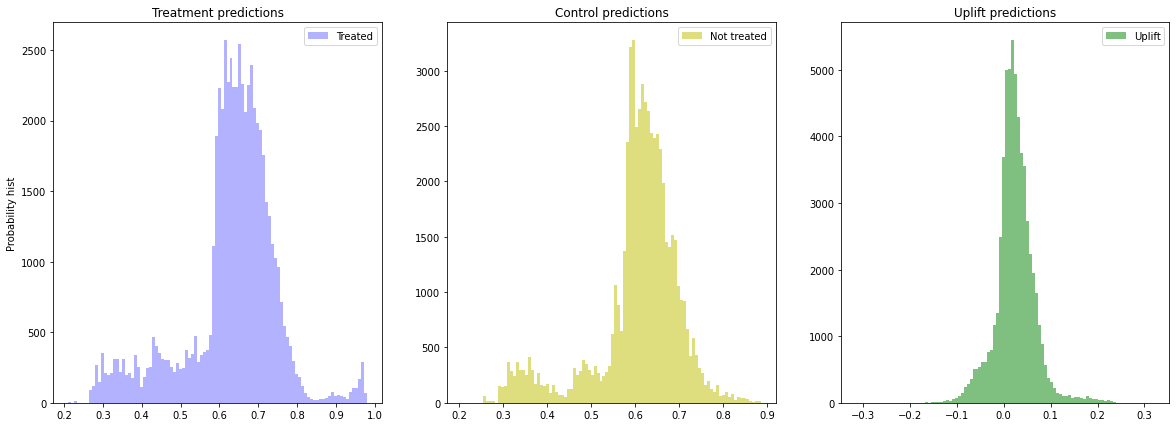

In [0]:
tm_ctrl = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='ddr_control'
)
tm_ctrl = tm_ctrl.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm_ctrl = tm_ctrl.predict(X_val)

tm_ctrl_score = uplift_at_k(y_true=y_val, uplift=uplift_tm_ctrl, treatment=treat_val, k=0.3)

models_results['approach'].append('TwoModels_ddr_control')
models_results['uplift@30%'].append(tm_ctrl_score)

plot_uplift_preds(trmnt_preds=tm_ctrl.trmnt_preds_, ctrl_preds=tm_ctrl.ctrl_preds_);

Similarly, you can first train the $P^T$ classifier, and then use its predictions as a feature for the $P^C$ classifier.

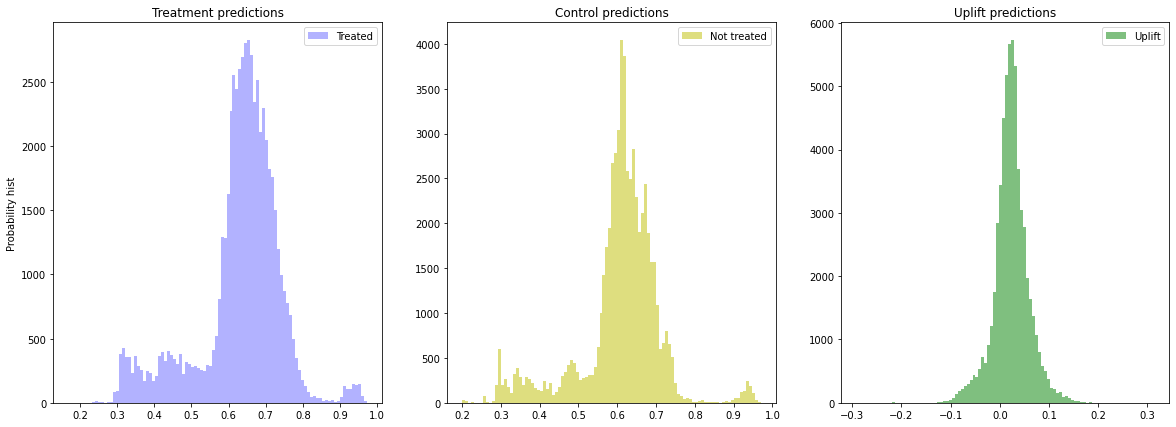

In [0]:
tm_trmnt = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='ddr_treatment'
)
tm_trmnt = tm_trmnt.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm_trmnt = tm_trmnt.predict(X_val)

tm_trmnt_score = uplift_at_k(y_true=y_val, uplift=uplift_tm_trmnt, treatment=treat_val, k=0.3)

models_results['approach'].append('TwoModels_ddr_treatment')
models_results['uplift@30%'].append(tm_trmnt_score)

plot_uplift_preds(trmnt_preds=tm_trmnt.trmnt_preds_, ctrl_preds=tm_trmnt.ctrl_preds_);

## Conclusion

Let's consider which method performed best in this task and use it to speed up the test sample:

In [0]:
pd.DataFrame(data=models_results).sort_values('uplift@30%', ascending=False)

,approach,uplift@30%
1,ClassTransformation,0.061775
2,TwoModels,0.051637
3,TwoModels_ddr_control,0.047793
0,SoloModel,0.041614
4,TwoModels_ddr_treatment,0.033752


From the table above you can see that the current task suits best for the approach to the transformation of the target line. Let's train the model on the entire sample and predict the test.

In [0]:
cm_full = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
cm_full = cm_full.fit(X_train_full, y_train_full, treat_train_full, estimator_fit_params={'cat_features': [1]})

X_test.loc[:, 'uplift'] = cm_full.predict(X_test.values)

sub = X_test[['uplift']].to_csv('sub1.csv')

!head -n 5 sub1.csv

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  


client_id,uplift
000048b7a6,0.03244481877693639
000073194a,0.029427607204029815
00007c7133,0.014729684558687728
00007f9014,0.02778484806513082


In [0]:
cm_full_fi = pd.DataFrame({
    'feature_name': cm_full.estimator.feature_names_,
    'feature_score': cm_full.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

cm_full_fi

,feature_name,feature_score
0,first_redeem_time,86.662273
1,age,5.582358
2,issue_redeem_delay,3.467160
3,first_issue_time,2.755578
4,gender,1.532631


This way we got acquainted with uplift modeling and considered the main basic approaches to its construction. What's next? Then you can plunge them into the intelligence analysis of data, generate some new features, select the models and their hyperparameters and learn new approaches and libraries.

**Thank you for reading to the end.**

**I will be pleased if you support the project with an star on [github](https://github.com/maks-sh/scikit-uplift/) or tell your friends about it.**